In [7]:
##DATA ANALYSIS OF USED CARS DATASET AND MACHINE LEARNING MODEL TO PREDICT THE PRICE OF A CAR BASED ON THE DATA PROJECT
#SYNTETAS MANOLIS
#15-05-2024

##########################################################################################################################################################################
# ##TABLE OF CONTENTS                                                                                                                                                    #
#                                                                                                                                                                        #
# #1.GETTING DATA FROM CSV FILE..........................................................................................................................................#
# #2.CLEANING AND PRPEPARING THE DATA....................................................................................................................................#
# #3.PERFORMING BASIC EXPLORATORY DATA ANALYSIS..........................................................................................................................#
# #4.VISUALIZING THE DATA ABOUT CAR BRANDS...............................................................................................................................#
# #5.VISUALIZING THE DATA ABOUT CAR MODELS...............................................................................................................................#
# #6.VISUALISING THE DATA ABOUT MOST VALUE FOR MONEY AND LEAST VALUE FOR MONEY MODELS....................................................................................#
# #7.VISUALIZING HP vs PRICE & MILEAGE vs PRICE TRENDS...................................................................................................................#
# #8.#VISUALISING STATISTICS OF CARS DETAILS.............................................................................................................................#
# #9.CREATING MACHINE LEARNING MODEL WHERE THE USER CAN INPUT THEIR OWN DETAILS AND THE MODEL WILL PREDICT THE PRICE OF THEIR CAR BASED ON THE DATA IN THE DATASET.......#
# #10.GETTING USER INPUT AND PREDICTING THE PRICE OF THEIR CAR...........................................................................................................#
# #11.VISUALISING NUMERICAL FEATURE IMPORTANCE...........................................................................................................................#
#                                                                                                                                                                        #
##########################################################################################################################################################################


#INSTALLING AND IMPORTING ALL REQUIRED LIBRARIRES
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install xgboost
%pip install plotly

import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import plotly.express as px


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [8]:
##1. GETTING DATA FROM CSV FILE

#specifying path of the used_cars.csv file
file_path = r"C:\Users\MS\Downloads\used_cars.csv" #prefix r is used to treat backlash as a normal character and not as an escape character

#saving the csv file into a pandas dataframe
df = pd.read_csv(file_path)

#checking the fist five rows of the csv file
df.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [9]:
##2.CLEANING AND PRPEPARING THE DATA

#dropping the rows with missing values
df.dropna(inplace=True)

#dropping the duplicate rows
df.drop_duplicates(inplace=True)

#resetting the index of the dataframe
df.reset_index(drop=True, inplace=True)

#rename milage column to mileage
df.rename(columns={'milage':'mileage'}, inplace=True)

#remove every model that doesnt have specify amount of horsepower in the column ENGINE 
df = df[df['engine'].str.contains('HP') == True]

#create new column that called HP from engine column with split inplace of the engine column
df['hp'] = df['engine'].str.split(' ').str[0]
df.drop(columns=['engine'], inplace=True)

#format the table so that seventh column is HP
df.insert(6, 'hp', df.pop('hp'))

#converting hp column to float type by replacing 'HP' and with empty space
df['hp'] = df['hp'].astype(str)
df['hp'] = df['hp'].str.replace('HP', '').str.replace(' ', '')
df['hp'] = df['hp'].astype(float)


#converting price column to float type by replacing '$' and ',' with empty space
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = df['price'].astype(float)

#converting mileage column to float type by replacing 'mi' and ',' with empty space 
df['mileage'] = df['mileage'].astype(str)
df['mileage'] = df['mileage'].str.replace('mi', '').str.replace(',', '').str.replace(' ', '')
df['mileage'] = df['mileage'].astype(float)

#convert every column header to uppercase   
df.columns = map(str.upper, df.columns)

#show the whole table
df.head()


,BRAND,MODEL,MODEL_YEAR,MILEAGE,FUEL_TYPE,TRANSMISSION,HP,EXT_COL,INT_COL,ACCIDENT,CLEAN_TITLE,PRICE
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,6-Speed A/T,300.0,Black,Black,At least 1 accident or damage reported,Yes,10300.0
2,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,7-Speed A/T,354.0,Black,Black,None reported,Yes,15500.0
3,Audi,S3 2.0T Premium Plus,2017,84000.0,Gasoline,6-Speed A/T,292.0,Blue,Black,None reported,Yes,31000.0
4,BMW,740 iL,2001,242000.0,Gasoline,A/T,282.0,Green,Green,None reported,Yes,7300.0
5,Lexus,RC 350 F Sport,2021,23436.0,Gasoline,6-Speed A/T,311.0,Black,Black,None reported,Yes,41927.0


In [10]:
##3.PERFORMING BASIC EXPLORATORY DATA ANALYSIS

print('Number of unique brands:', df['BRAND'].nunique()) #using nunique to return the number of unique brands
print('Number of unique models:', df['MODEL'].nunique())
print('Number of all cars:', df['MODEL'].count())
print('\n')
print('Minimum price:', df['PRICE'].min())
print('Maximum price:', df['PRICE'].max())
print('Mean price:', df['PRICE'].mean())
print('Standard deviation of price:', df['PRICE'].std())    
print('\n')
print('Minimum mileage:', df['MILEAGE'].min())
print('Maximum mileage:', df['MILEAGE'].max())
print('Mean mileage:', df['MILEAGE'].mean())
print('Standard deviation of mileage:', df['MILEAGE'].std())
print('\n')
print('Minimum hp:', df['HP'].min())
print('Maximum hp:', df['HP'].max())
print('Mean hp:', df['HP'].mean())
print('Standard deviation of hp:', df['HP'].std())

#identify and print the top 10 brands that have the highest average price
print("\n\nTop 10 most expensive brands:\n\n", df.groupby('BRAND')['PRICE'].mean().sort_values(ascending=False).head(10))

#identify and print the top 10 most expensive models
print("\n\nTop 10 most expensive models:\n\n", df.groupby('MODEL')['PRICE'].max().sort_values(ascending=False).head(10))


Number of unique brands: 51
Number of unique models: 1506
Number of all cars: 2982


Minimum price: 2000.0
Maximum price: 2954083.0
Mean price: 37905.671696847756
Standard deviation of price: 71387.1611707031


Minimum mileage: 100.0
Maximum mileage: 405000.0
Mean mileage: 73923.78906773977
Standard deviation of mileage: 53538.56872328629


Minimum hp: 70.0
Maximum hp: 797.0
Mean hp: 325.75687458081825
Standard deviation of hp: 112.97690705493368


Top 10 most expensive brands:

 BRAND
Lamborghini    251594.923077
Ferrari        236473.500000
McLaren        216331.666667
Rolls-Royce    157775.000000
Maserati       146739.269231
Aston           94082.666667
Bentley         88779.190476
Porsche         80604.891156
Maybach         64250.000000
Lotus           58416.666667
Name: PRICE, dtype: float64


Top 10 most expensive models:

 MODEL
Quattroporte Base     2954083.0
Carrera GT Base       1599000.0
Aventador SVJ Base     649999.0
Aventador S Base       491836.0
Viper GTC              

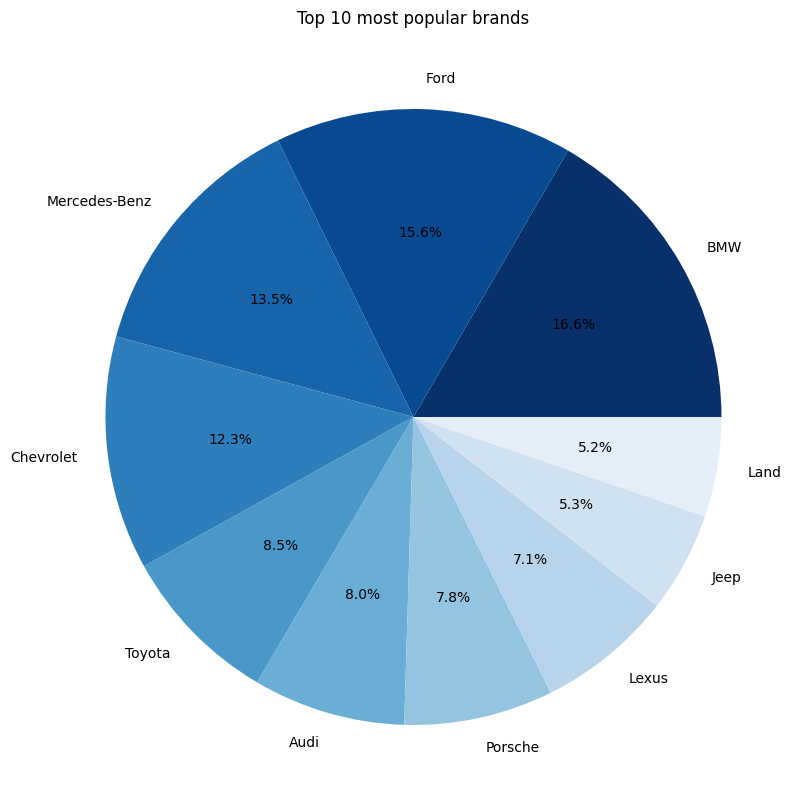

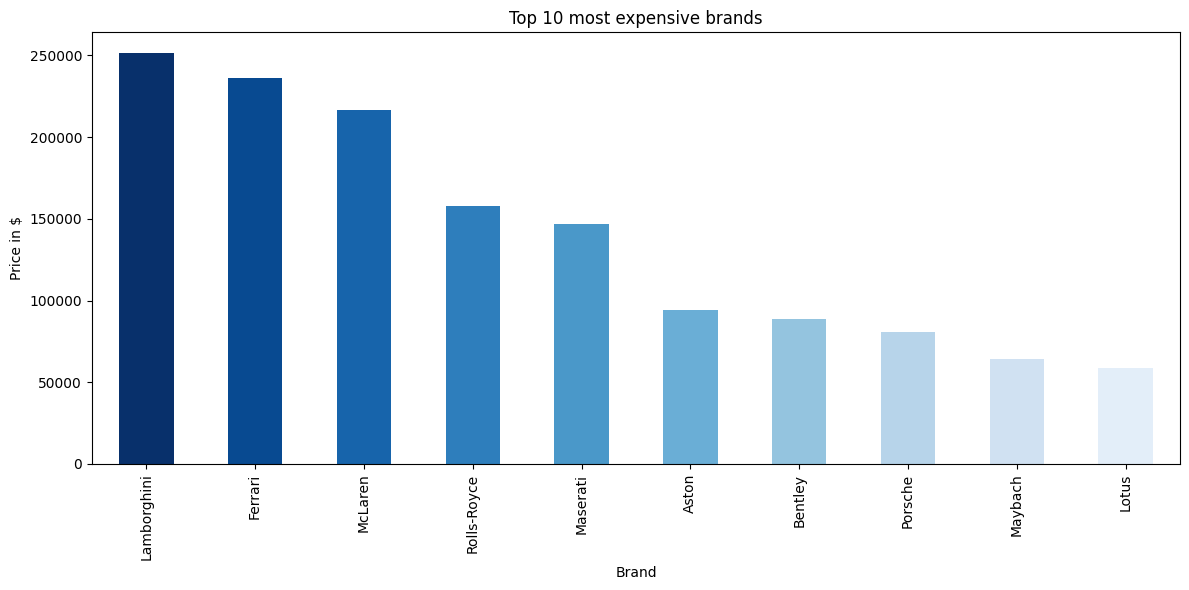

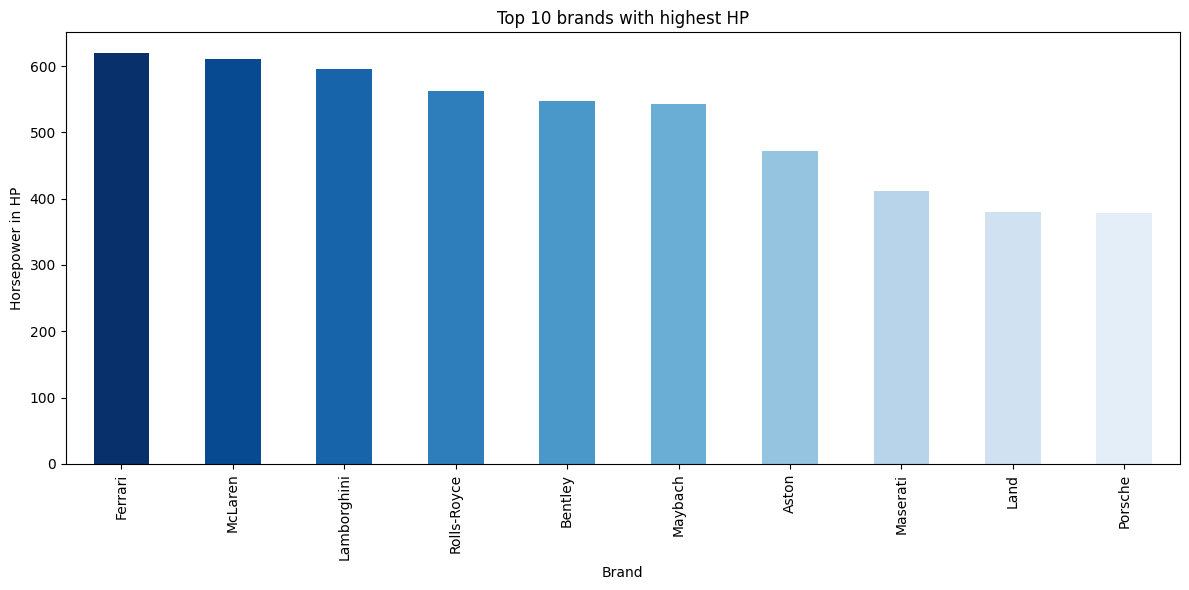

In [11]:
##4.VISUALIZING THE DATA ABOUT CAR BRANDS

#number of shades of blue used for coloring the plots
shades_of_blue = 10


#pie chart of top 10 most popular brands
plt.figure(figsize=(20,10))
plt.pie(df['BRAND'].value_counts().head(10), labels=df['BRAND'].value_counts().head(10).index,autopct='%1.1f%%', colors=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue))) 
#.value_counts() is used to count the number of times each brand appears in the dataset
#.head(10) is used to return the top 10 most popular brands
#.index is used to return the index of the top 10 most popular brands 
#autopct is used to show the percentage of each pie slice 
#plt.cm.Blues is used to specify the color palette 
#np.linspace is used to specify the number of   
plt.title('Top 10 most popular brands')
plt.show()

#bar chart of the top 10 most expensive brands 
plt.figure(figsize=(12,6))
df.groupby('BRAND')['PRICE'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue)))   
plt.xlabel('Brand')
plt.ylabel('Price in $')
plt.title('Top 10 most expensive brands')
#.mean() is used to return the average price of each brand
#.sort_values(ascending=False) is used to sort the values in descending order
plt.tight_layout()

#create chart of brands with highest HP
plt.figure(figsize=(12,6))
df.groupby('BRAND')['HP'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue)))
plt.xlabel('Brand')
plt.ylabel('Horsepower in HP')
plt.title('Top 10 brands with highest HP')
plt.tight_layout()


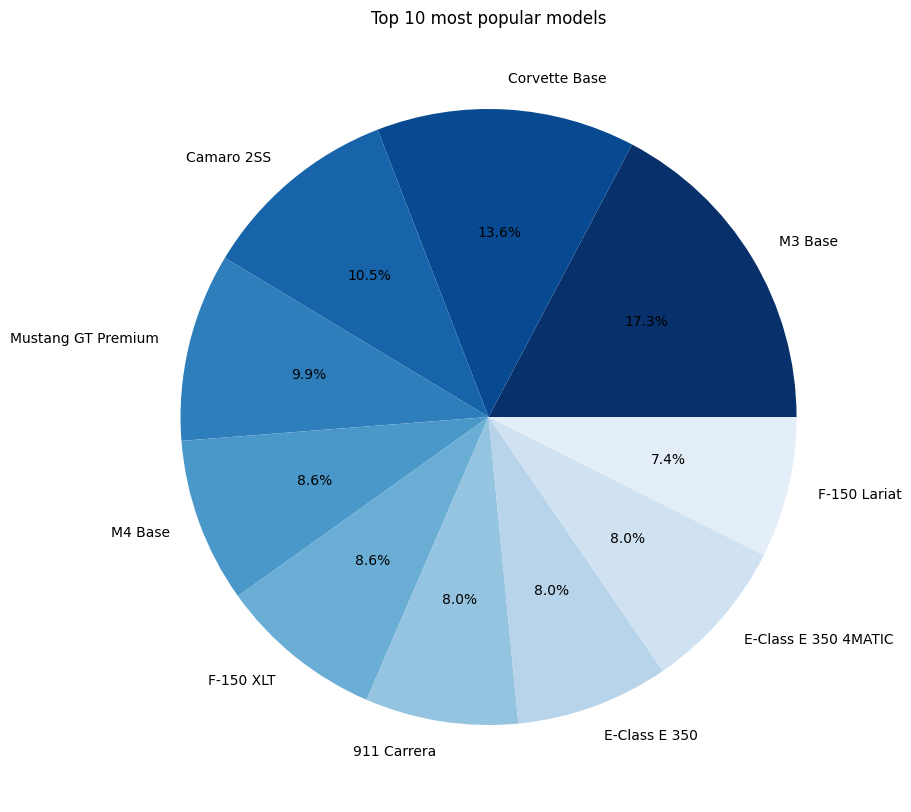

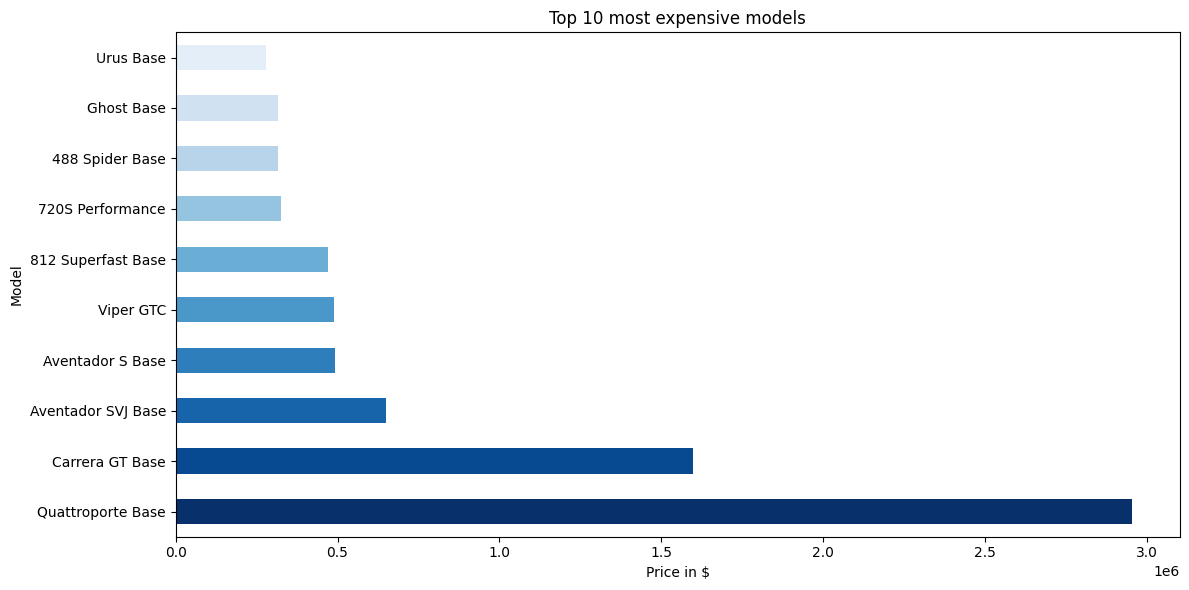

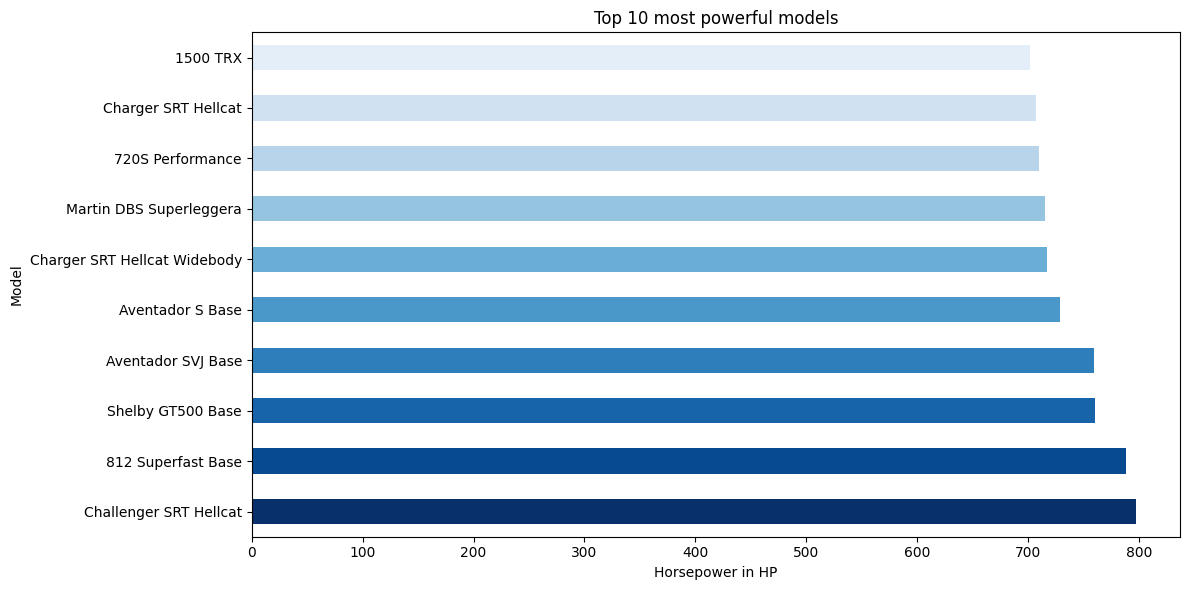

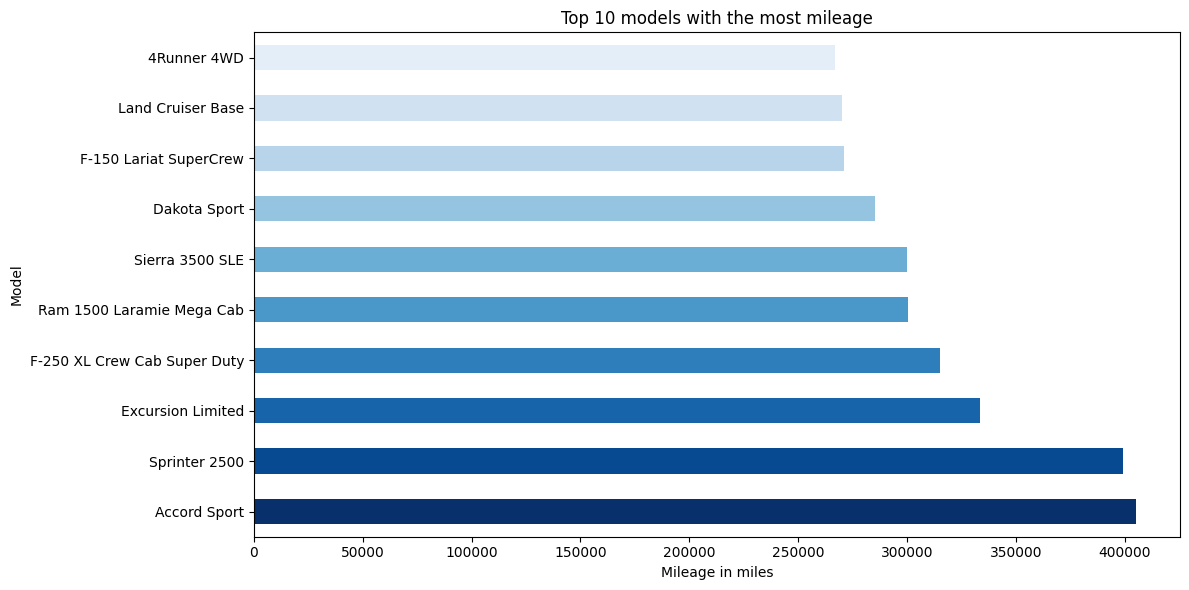

In [12]:
##5.VISUALIZING THE DATA ABOUT CAR MODELS

#pie chart of top 10 most popular models
plt.figure(figsize=(20,10))
plt.pie(df['MODEL'].value_counts().head(10), labels=df['MODEL'].value_counts().head(10).index,autopct='%1.1f%%', colors=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue)))
plt.title('Top 10 most popular models')
plt.show()

#barh chart of the top 10 most expensive models
plt.figure(figsize=(12,6))
df.groupby('MODEL')['PRICE'].max().sort_values(ascending=False).head(10).plot(kind='barh', color=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue)))
plt.ylabel('Model')
plt.xlabel('Price in $')
plt.title('Top 10 most expensive models')
plt.tight_layout()

#barh chart of the top 10 most powerful models 
plt.figure(figsize=(12,6))
df.groupby('MODEL')['HP'].max().sort_values(ascending=False).head(10).plot(kind='barh', color=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue)))
plt.ylabel('Model')
plt.xlabel('Horsepower in HP')
plt.title('Top 10 most powerful models')
plt.tight_layout()

#barh of the top 10 models with the most mileage
plt.figure(figsize=(12,6))
df.groupby('MODEL')['MILEAGE'].max().sort_values(ascending=False).head(10).plot(kind='barh', color=plt.cm.Blues(np.linspace(1, 0.1, shades_of_blue)))
plt.ylabel('Model')
plt.xlabel('Mileage in miles')
plt.title('Top 10 models with the most mileage')
plt.tight_layout()


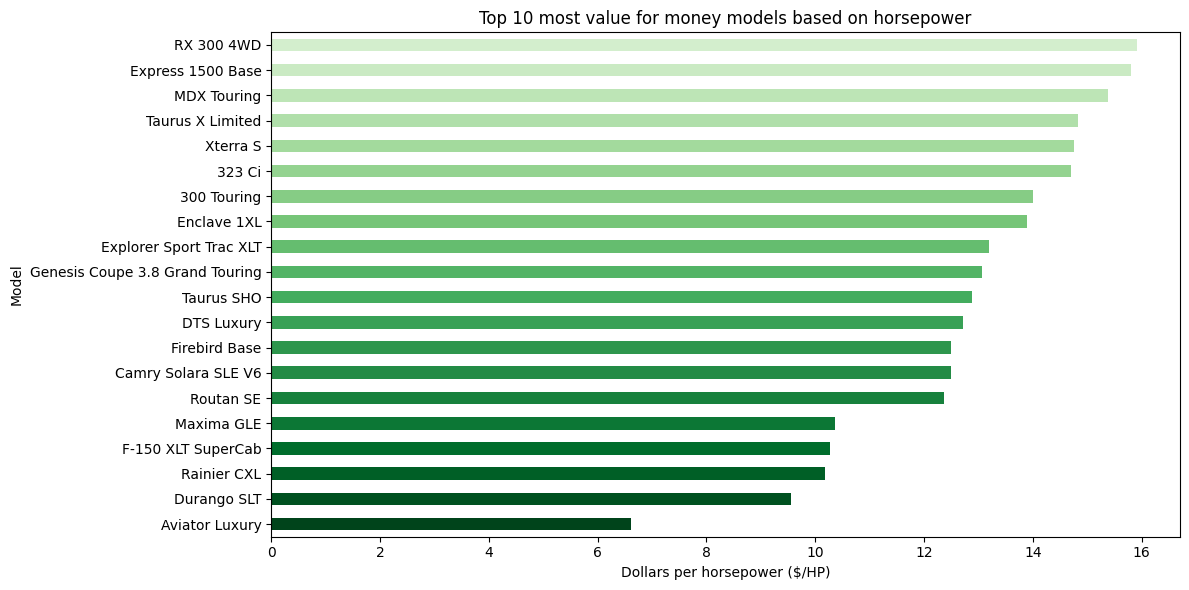

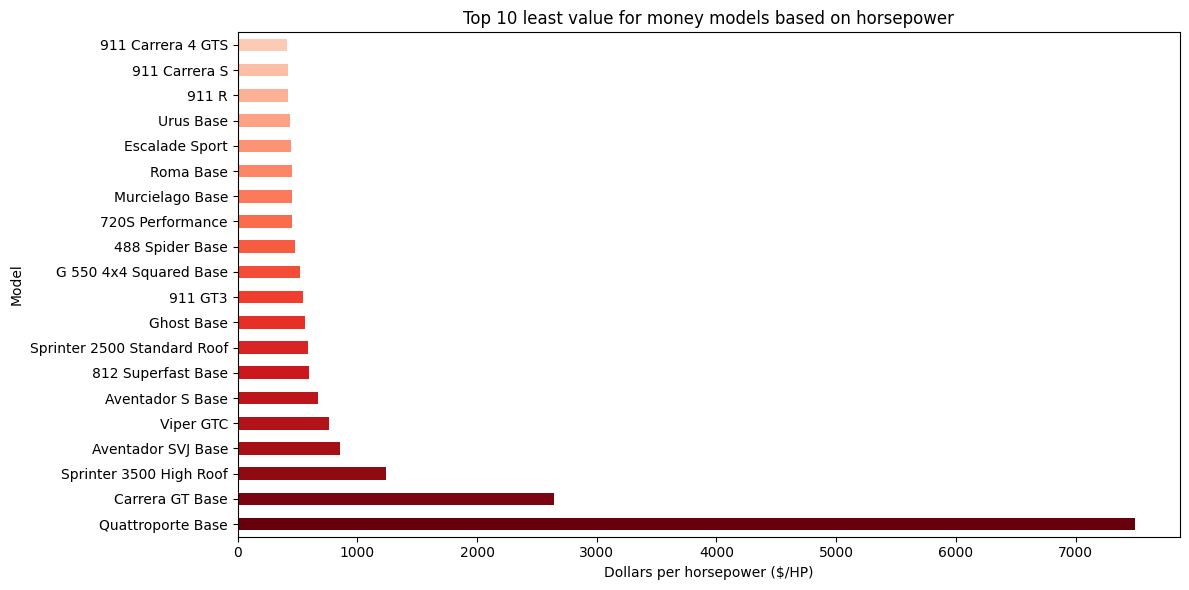

In [13]:
##6.VISUALISING THE DATA ABOUT MOST VALUE FOR MONEY AND LEAST VALUE FOR MONEY MODELS

shades_of_green = 20
shades_of_red = 20
df['DOLLARS_PER_HP'] = df['PRICE']/df['HP']

#barh chart of the top 10 models with the least amount of dollars per horsepower
plt.figure(figsize=(12,6))
df.groupby('MODEL')['DOLLARS_PER_HP'].min().sort_values(ascending=True).head(20).plot(kind='barh', color=plt.cm.Greens(np.linspace(1, 0.2, shades_of_green)))
plt.xlabel('Dollars per horsepower ($/HP)')
plt.ylabel('Model')
plt.title('Top 10 most value for money models based on horsepower')
plt.tight_layout()

#barh chart of the top 10 models with the most amount of dollars per horsepower
plt.figure(figsize=(12,6))
df.groupby('MODEL')['DOLLARS_PER_HP'].max().sort_values(ascending=False).head(20).plot(kind='barh', color=plt.cm.Reds(np.linspace(1, 0.2, shades_of_red)))   
plt.xlabel('Dollars per horsepower ($/HP)')
plt.ylabel('Model')
plt.title('Top 10 least value for money models based on horsepower')
plt.tight_layout()




Text(0.5, 1.0, 'Mileage vs Price')

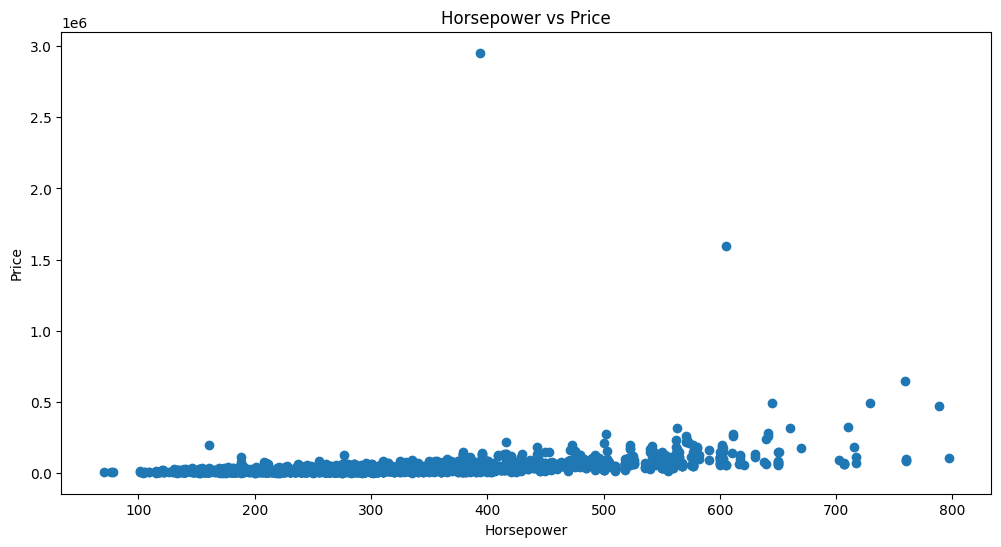

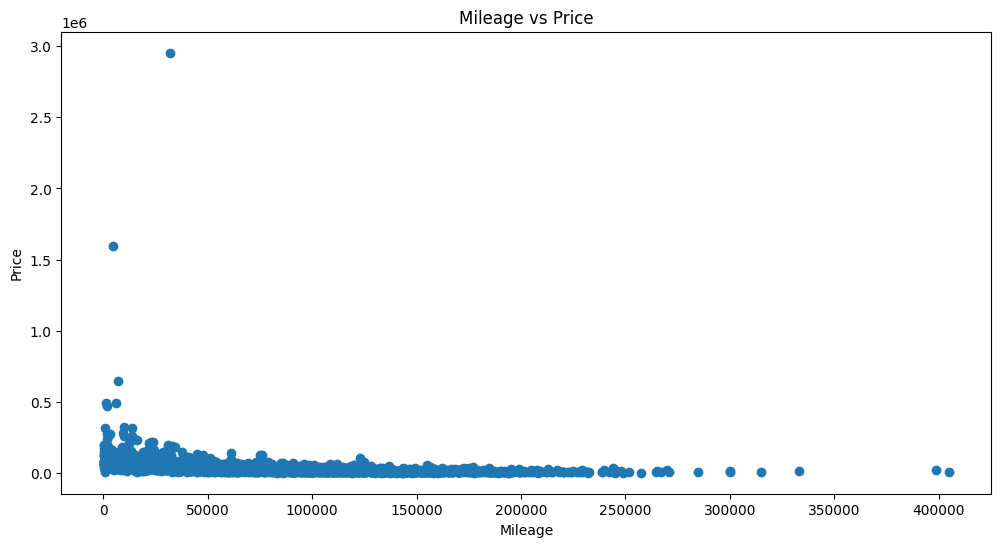

In [14]:
##7.VISUALIZING HP vs PRICE  &  MILEAGE vs PRICE TRENDS

#scatter chart of price vs HP
plt.figure(figsize=(12,6))
plt.scatter(df['HP'], df['PRICE'])
plt.xlabel('Horsepower')
plt.ylabel('Price')
plt.title('Horsepower vs Price')

#scatter chart of price vs mileage
plt.figure(figsize=(12,6))
plt.scatter(df['MILEAGE'], df['PRICE'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Mileage vs Price')

Text(0.5, 1.0, 'Count of cars that have been on an accident or not')

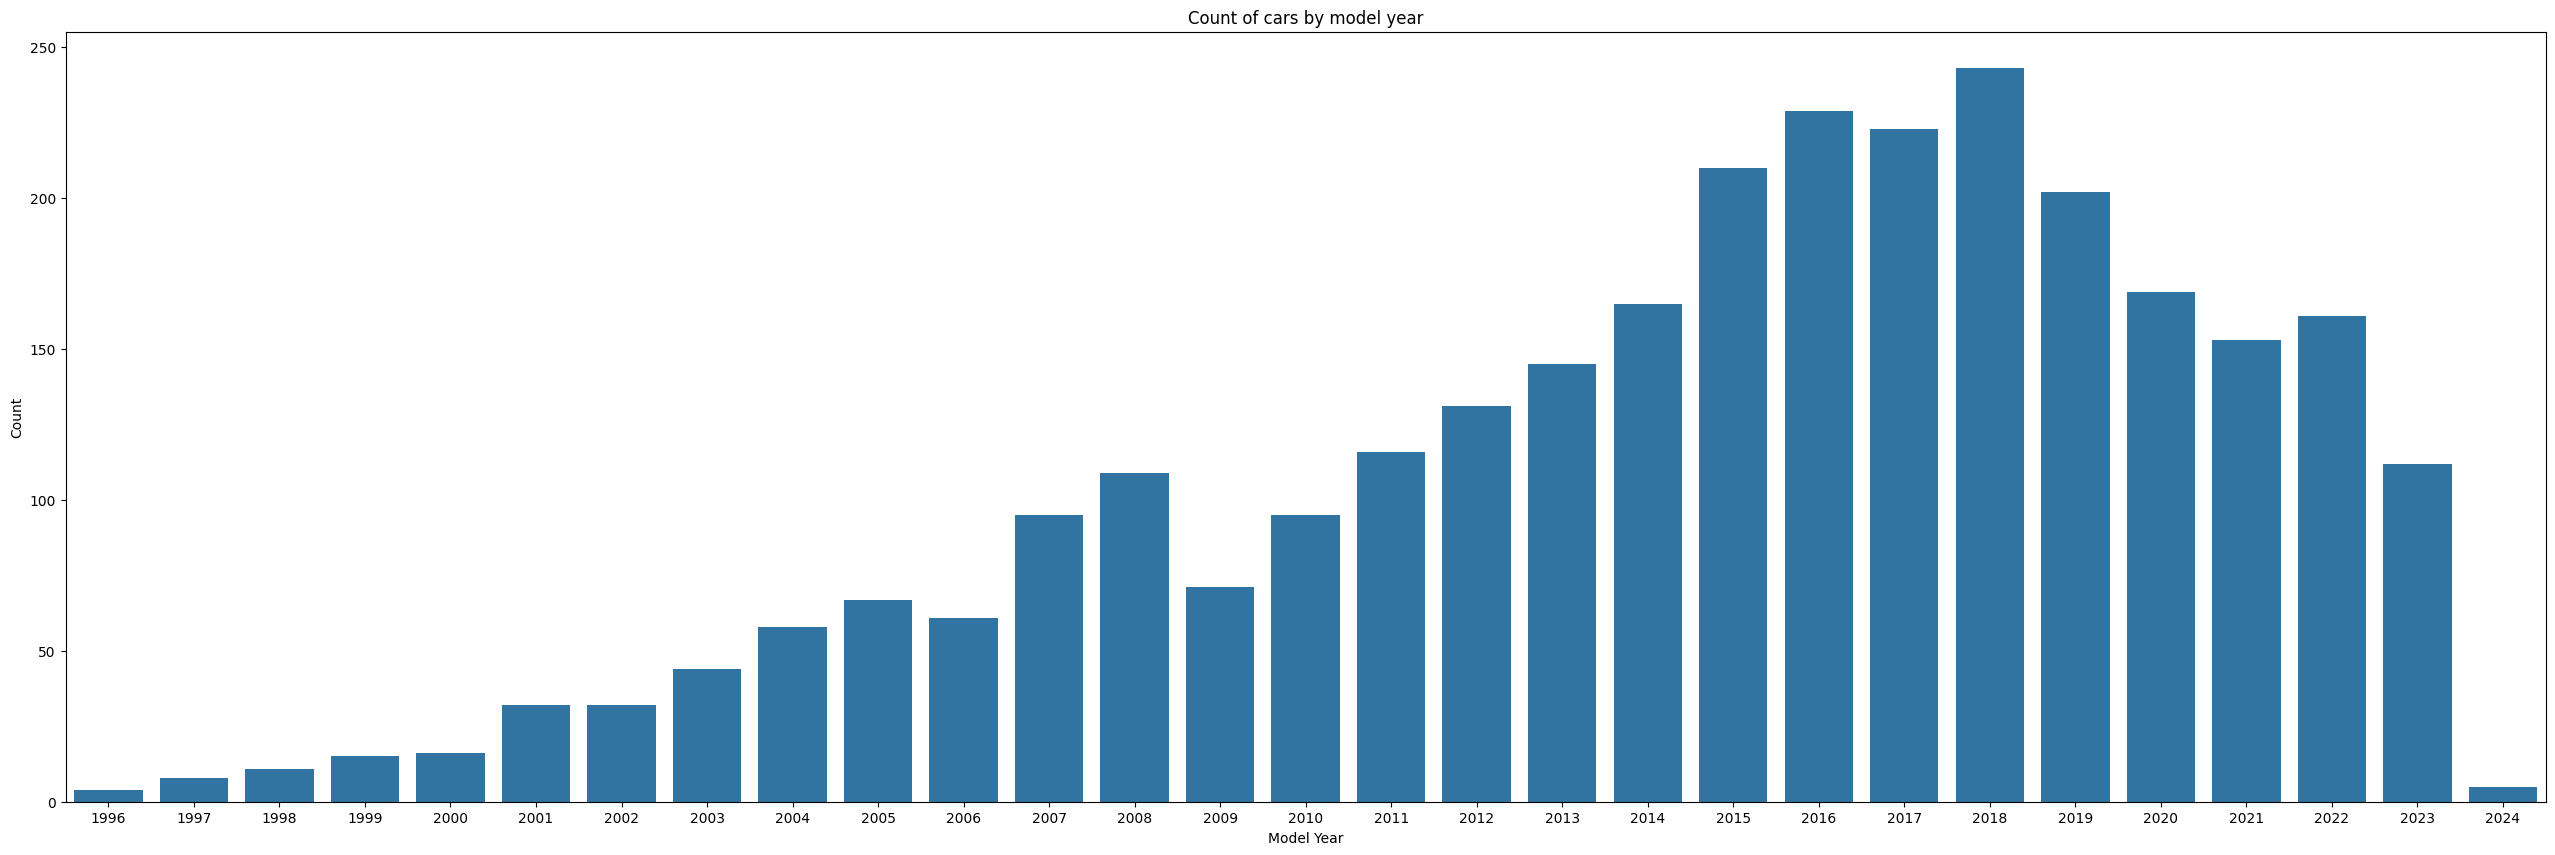

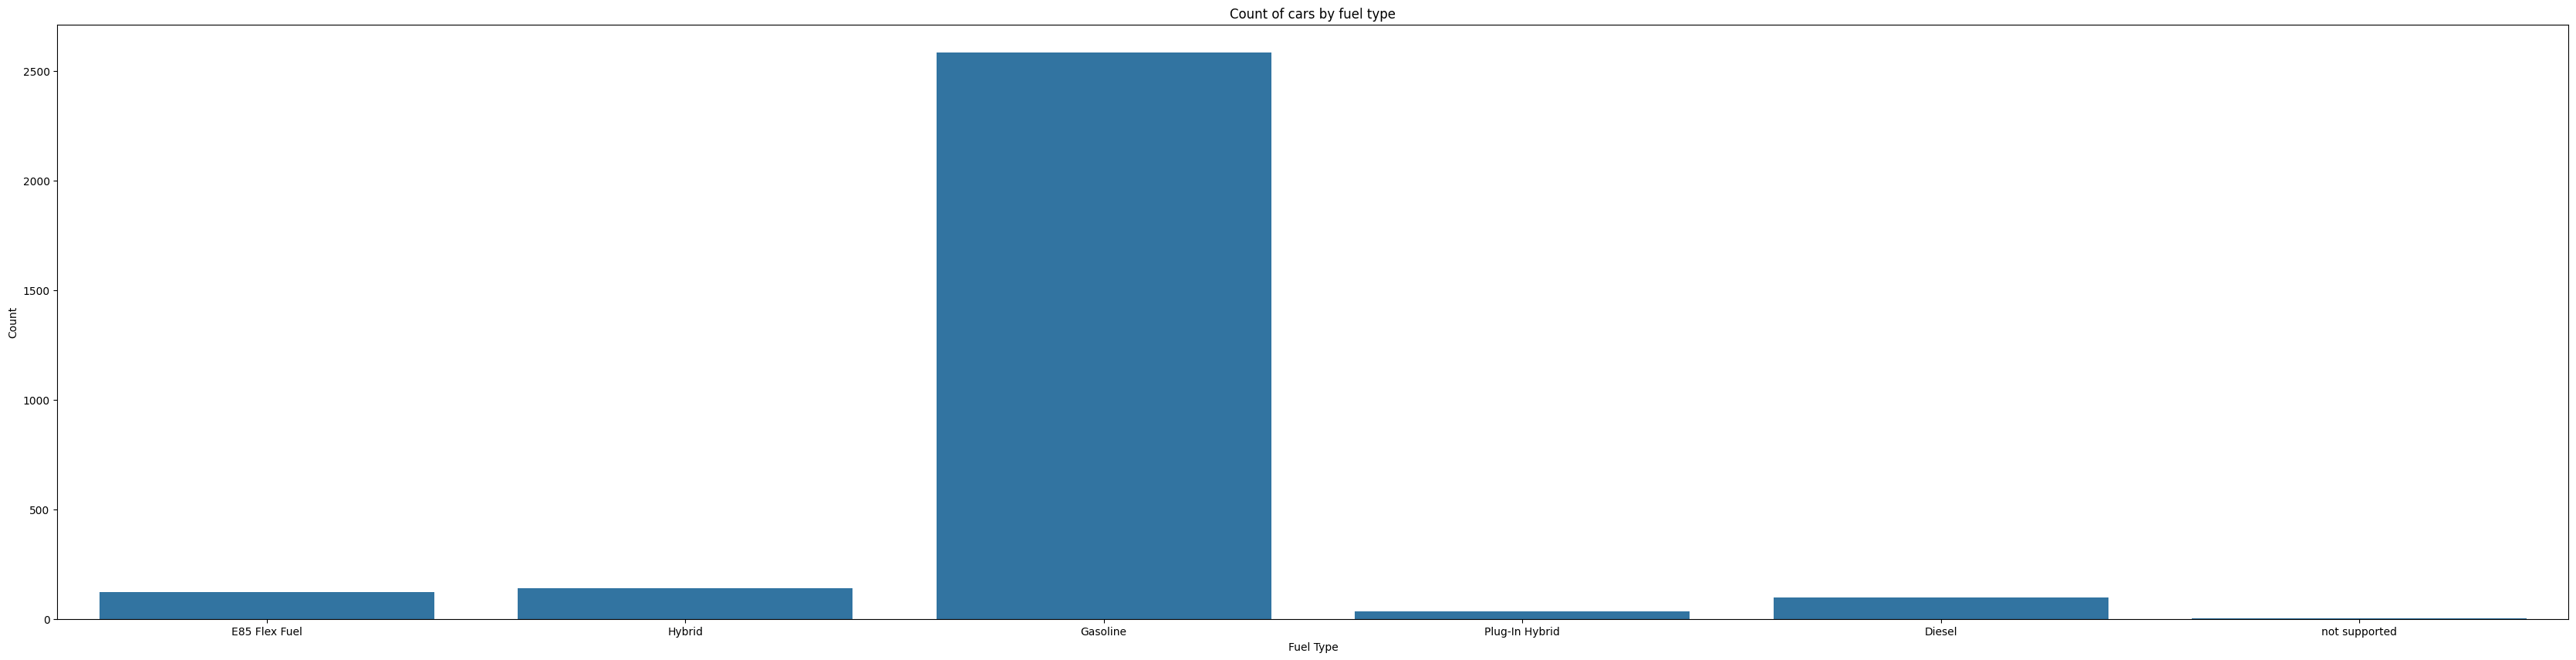

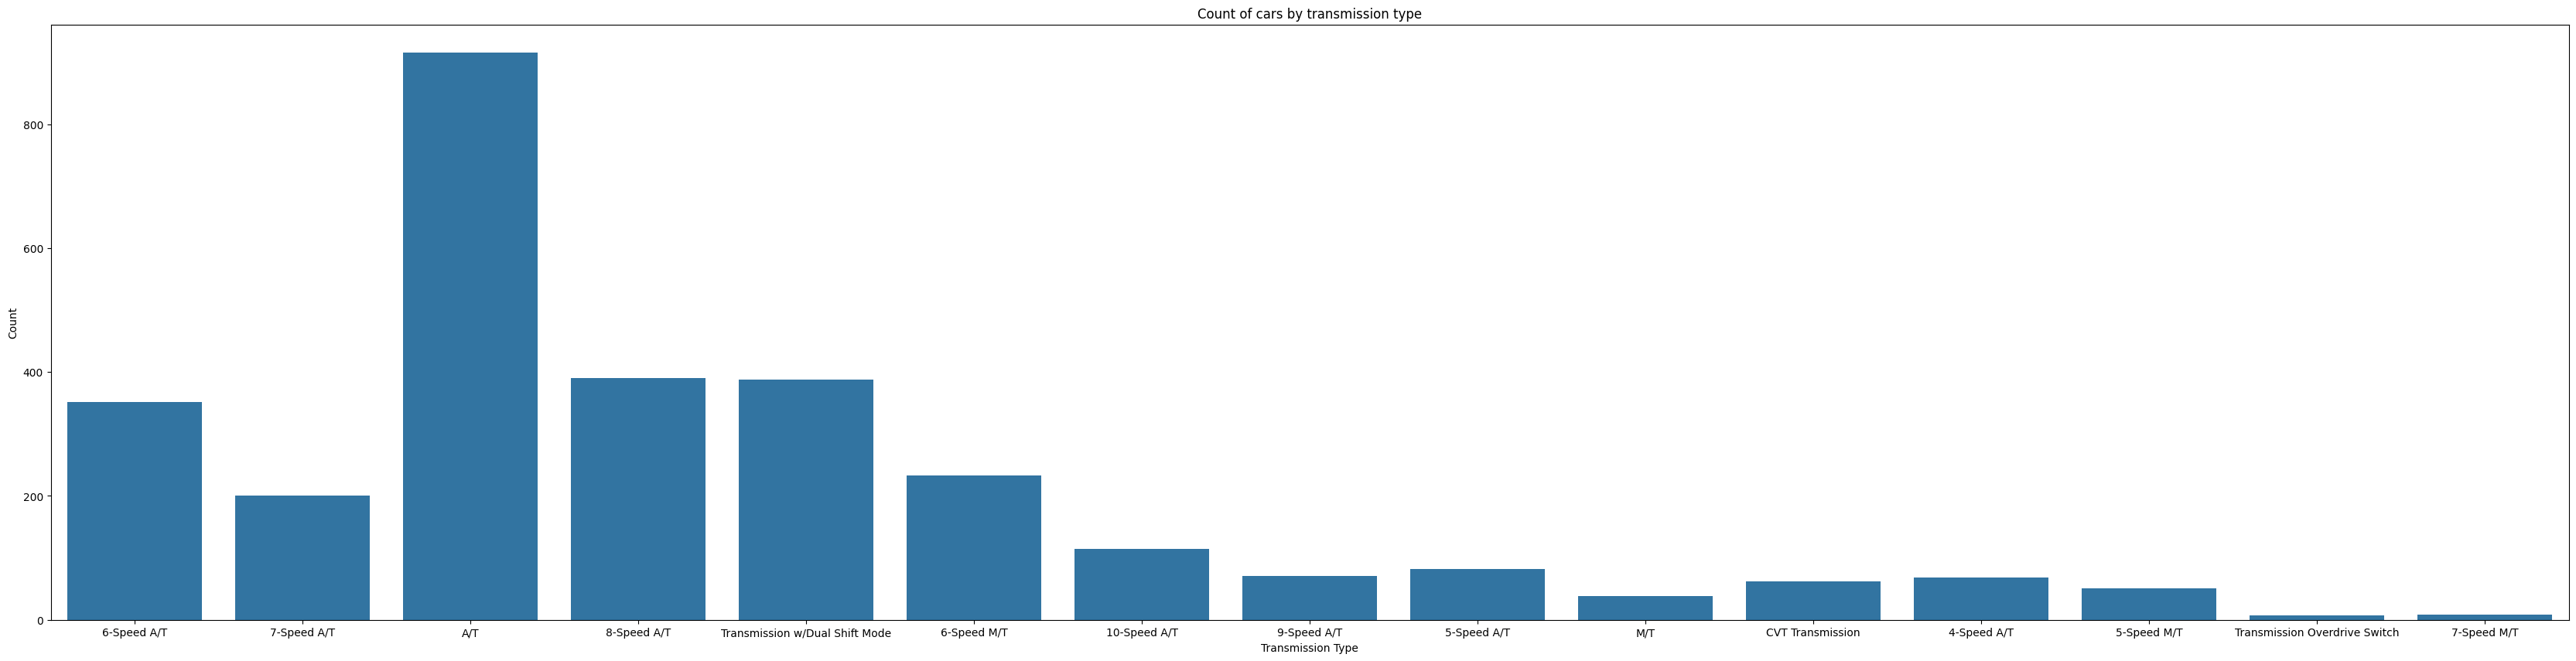

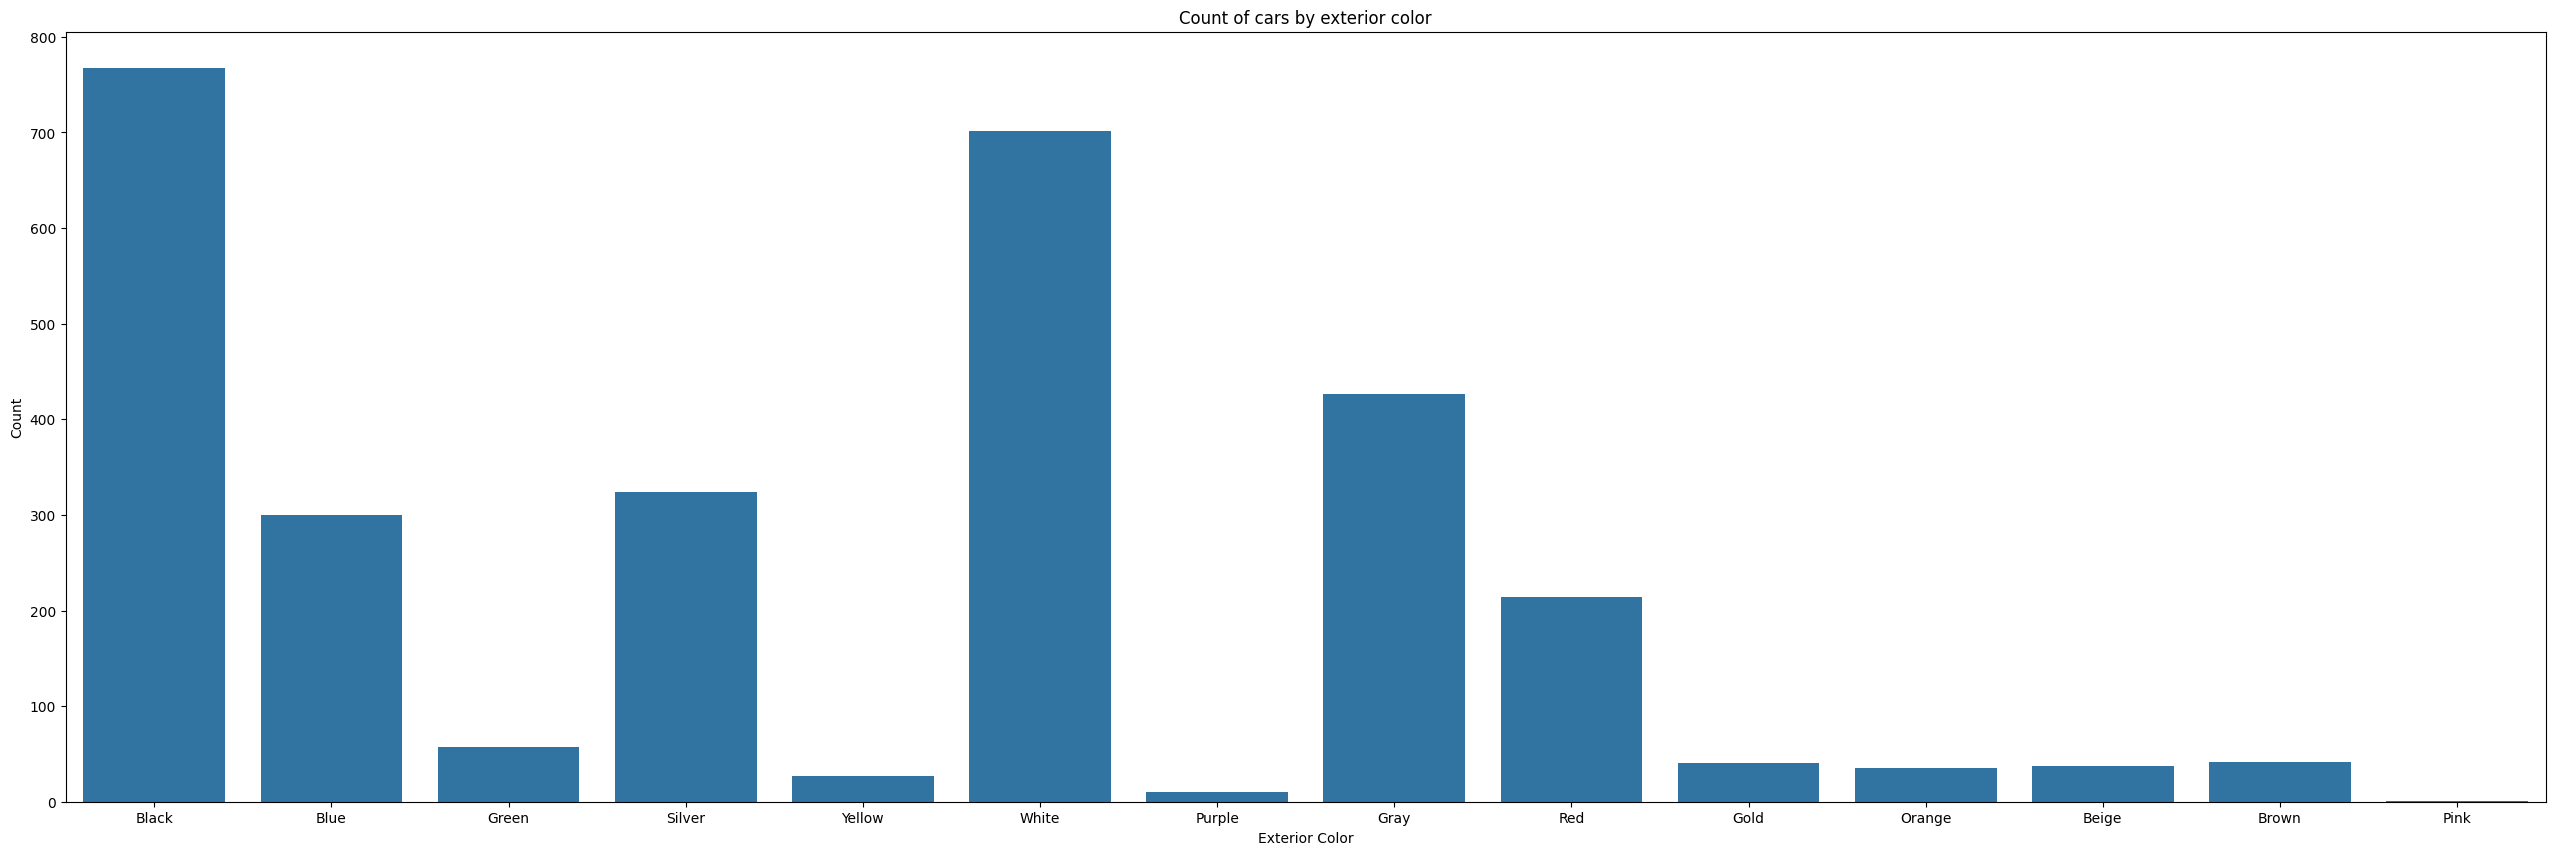

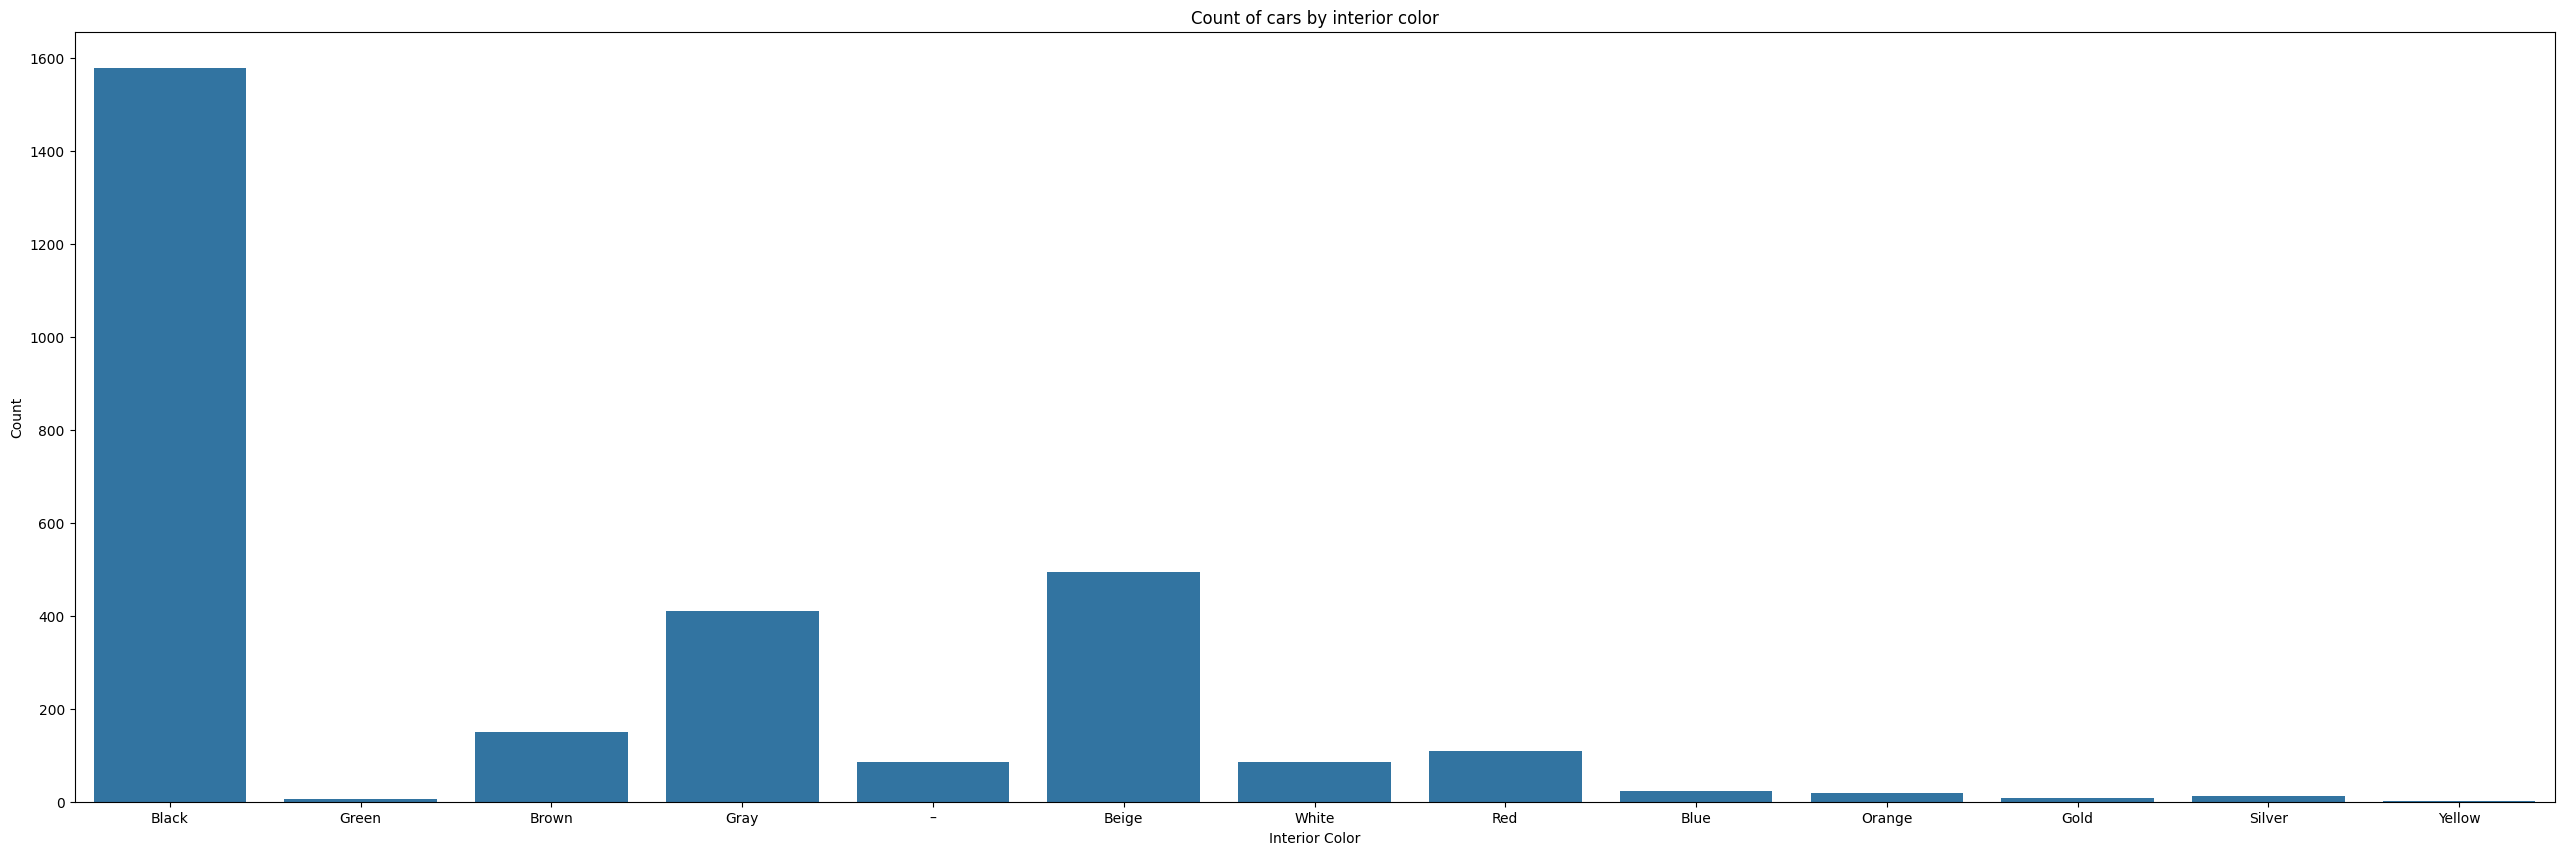

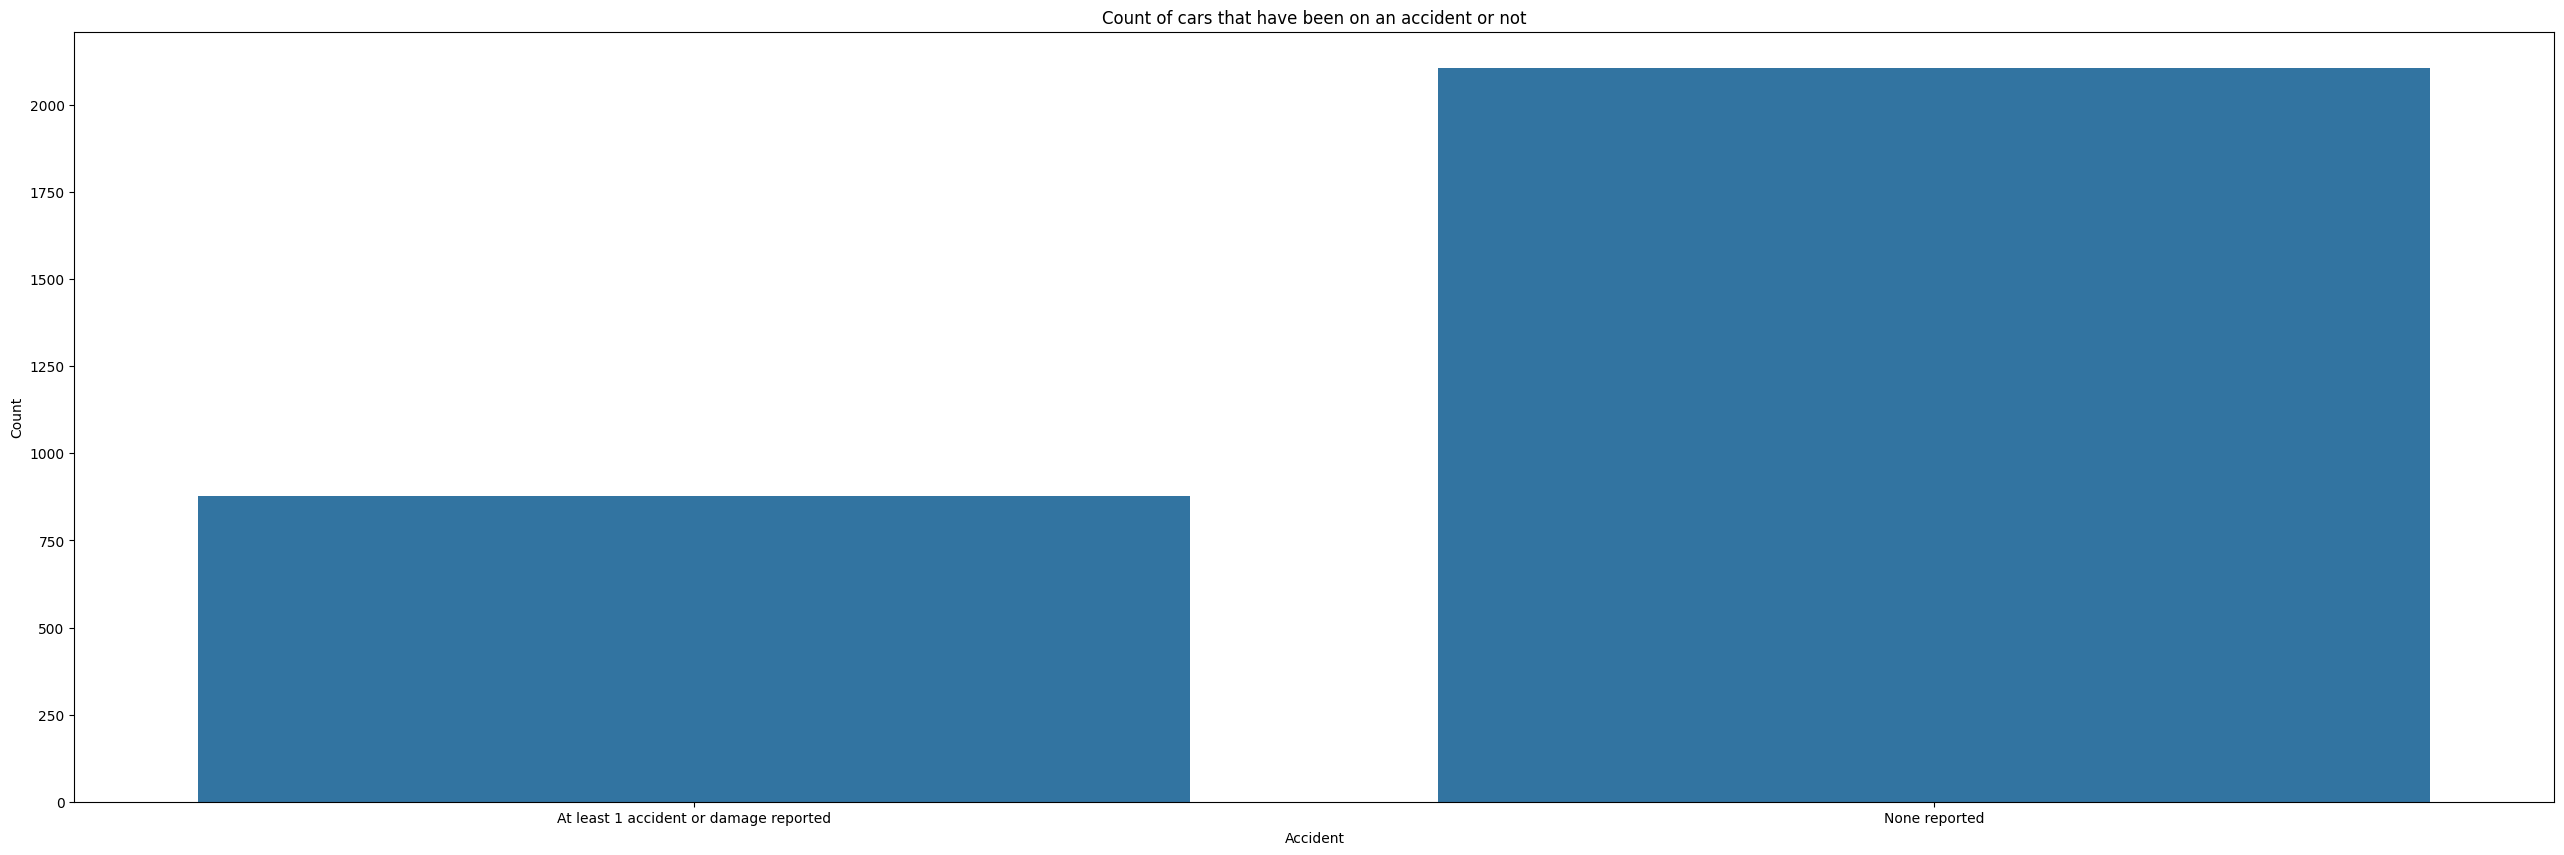

In [15]:
##8.VISUALISING STATISTICS OF CARS DETAILS

#sns countplot chart of count of cars by model year
plt.figure(figsize=(32,10))
sns.countplot(x=df['MODEL_YEAR'], data = df)
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.title('Count of cars by model year')

#sns countplot chart of count of cars by fuel type
plt.figure(figsize=(42,10))
sns.countplot(x=df['FUEL_TYPE'], data = df)
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.title('Count of cars by fuel type')

#sns countplot chart of count of cars by transmission type	
plt.figure(figsize=(42,10))
sns.countplot(x=df['TRANSMISSION'], data = df)
plt.xlabel('Transmission Type')
plt.ylabel('Count')
plt.title('Count of cars by transmission type')

#sns countplot chart of count og cars by exterior color
plt.figure(figsize=(32,10))
sns.countplot(x=df['EXT_COL'], data = df)
plt.xlabel('Exterior Color')
plt.ylabel('Count')
plt.title('Count of cars by exterior color')

#sns countplot chart of count of cars by interior color 
plt.figure(figsize=(32,10))
sns.countplot(x=df['INT_COL'], data = df)
plt.xlabel('Interior Color')
plt.ylabel('Count')
plt.title('Count of cars by interior color')

#sns countplot chart of count of cars that have been on an accident or not
plt.figure(figsize=(32,10))
sns.countplot(x=df['ACCIDENT'], data = df)
plt.xlabel('Accident')
plt.ylabel('Count')
plt.title('Count of cars that have been on an accident or not')


In [16]:
##9.CREATING MACHINE LEARNING MODEL WHERE THE USER CAN INPUT THEIR OWN DETAILS AND THE MODEL WILL PREDICT THE PRICE OF THEIR CAR BASED ON THE DATA IN THE DATASET

#define categorical columns
categorical_cols = ['BRAND', 'MODEL', 'FUEL_TYPE', 'TRANSMISSION', 'EXT_COL', 'INT_COL','ACCIDENT', 'CLEAN_TITLE']
#define numerical columns
numerical_cols = ['MODEL_YEAR','MILEAGE', 'HP']

#create aditional column that leads to more accurate predictions
df['CAR_AGE'] = 2024 - df['MODEL_YEAR']

#update numerical columns
numerical_cols.append('CAR_AGE')

#split data into X and y where x is the features and y is the target variable
X = df[categorical_cols + numerical_cols]
y = df['PRICE']

#preprocessing pipeline 
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols),('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

##split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#apply preprocessing pipeline to training data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Convert data into DMatrix format for xgboost 
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

#define parameters for grid search
param_grid = {
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

#initialise xgboost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

#perform grid search with cross validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,scoring='neg_mean_absolute_error', n_jobs=-1)

#fit the model 
grid_search.fit(X_train, y_train)

#best parameters from grid search
best_params = grid_search.best_params_
print('Best Parameters found: ', best_params)

#evaluate xgboost model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error with optimised model: ', mae)

#define function to predict price of car based on user input
def predict_price(user_input_dict):
    user_input_df=pd.DataFrame([user_input_dict])
    user_input_df['CAR_AGE'] = 2024 - user_input_df['MODEL_YEAR'] 
    user_input_processed = preprocessor.transform(user_input_df)
    predicted_price=best_model.predict(user_input_processed)
    return(predicted_price[0])
 

#prompt user for input
def get_user_input():
    user_input = {}
    for column in categorical_cols + numerical_cols[:-1]:#removing new car age column from user input
        user_input[column] = input(f"Enter {column.replace('_', ' ')} : ")

    #convert appropriate inputs to numeric types
    user_input['MODEL_YEAR'] = int(user_input['MODEL_YEAR'])
    user_input['HP'] = float(user_input['HP'])
    user_input['MILEAGE'] = float(user_input['MILEAGE'])

    return(user_input)




Best Parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Mean Absolute Error with optimised model:  8934.662263138609


In [18]:
##10.GETTING USER INPUT AND PREDICTING THE PRICE OF THEIR CAR

user_input = get_user_input()
predicted_price = predict_price(user_input)
print(user_input)
print(f"The predicted price of the car is ${predicted_price}")



{'BRAND': 'BMW', 'MODEL': 'M3 Base', 'FUEL_TYPE': 'Gasoline', 'TRANSMISSION': 'Transmission w/Dual Shift Mode', 'EXT_COL': 'Black', 'INT_COL': 'Black', 'ACCIDENT': 'None reported', 'CLEAN_TITLE': 'Yes', 'MODEL_YEAR': 2018, 'MILEAGE': 65000.0, 'HP': 425.0}
The predicted price of the car is $51646.734375


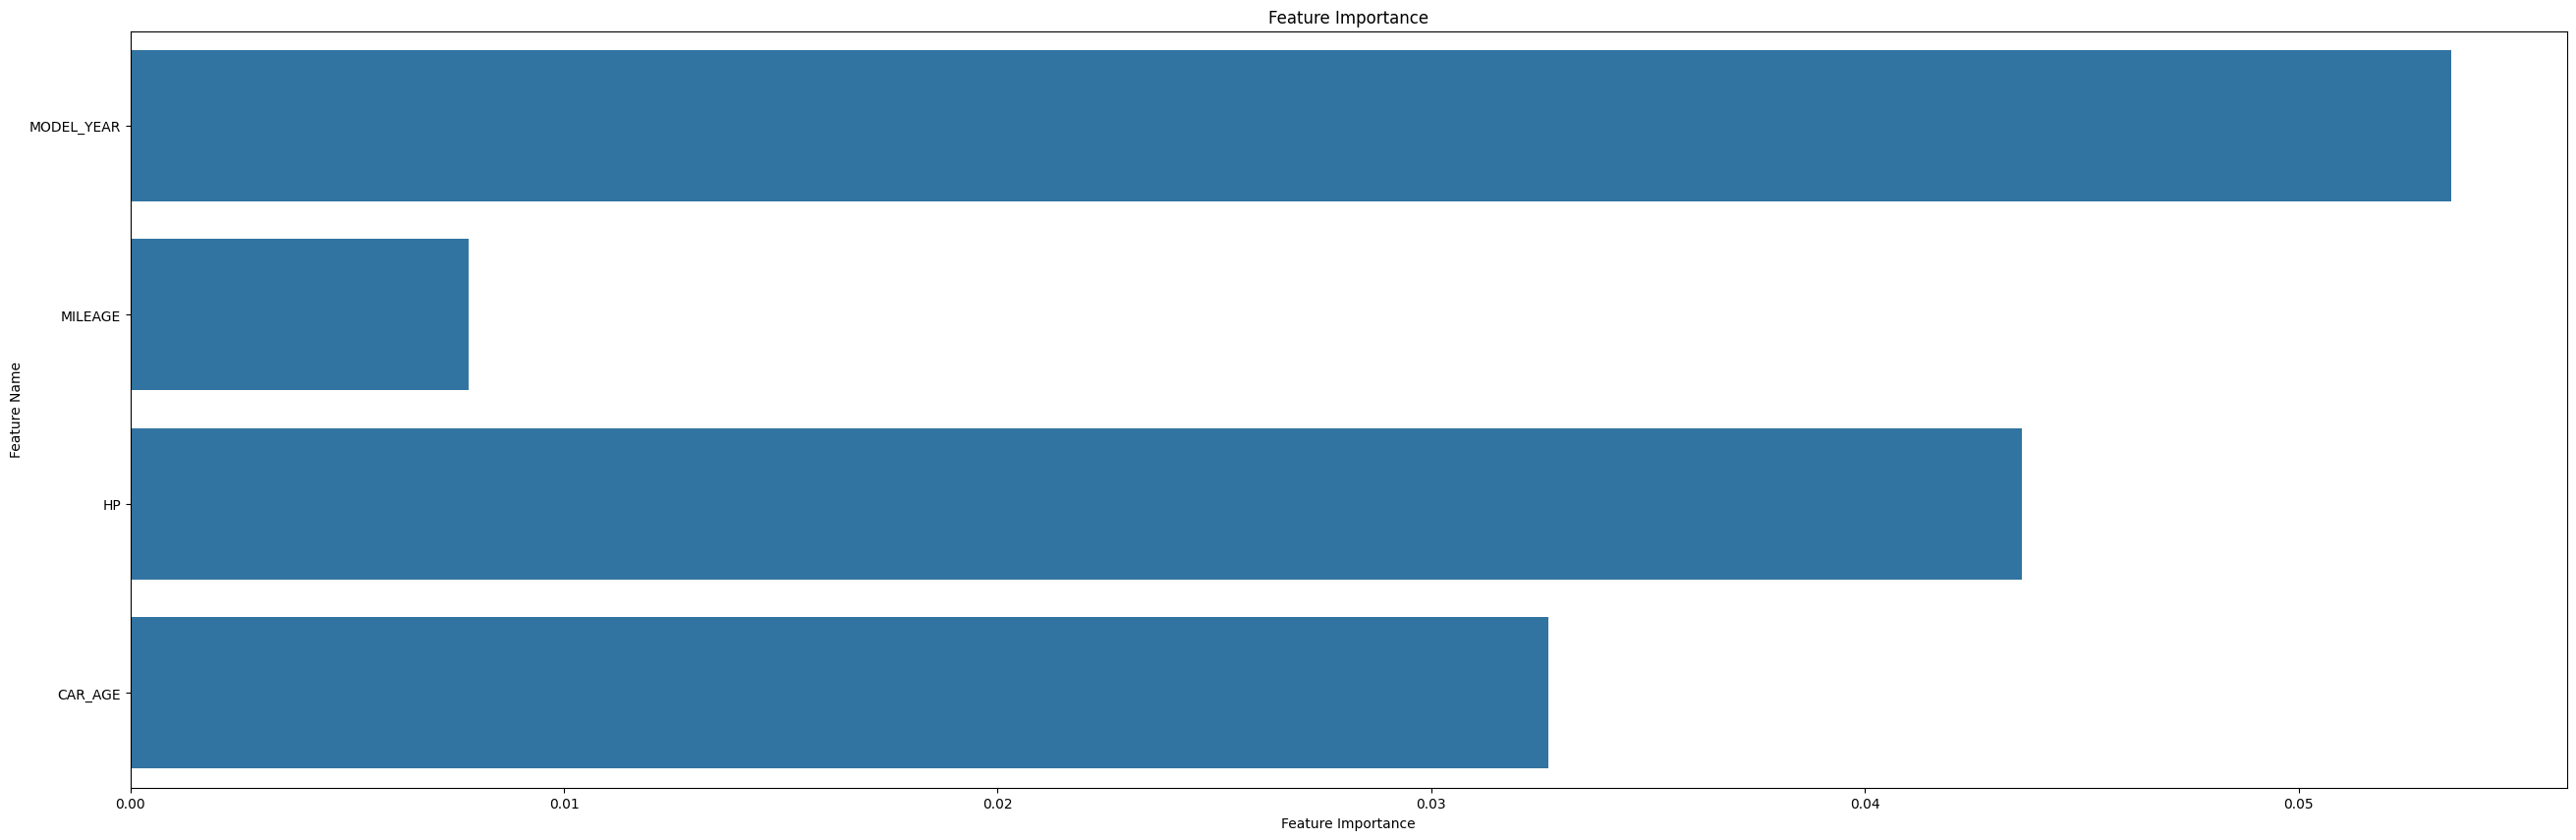

In [19]:
##11.VISUALISING NUMERICAL FEATURE IMPORTANCE

numerical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(numerical_cols).tolist() 
numerical_feature_importances = grid_search.best_estimator_.feature_importances_[:len(numerical_feature_names)]

numerical_importance_df = pd.DataFrame({'feature': numerical_feature_names, 'importance': numerical_feature_importances})

plt.figure(figsize=(32,10))
sns.barplot(x='importance', y='feature', data=numerical_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()